# met2rep - create reports summarizing the metrics calculated in `cen2met`

With the metrics characterizing the output of the experimental and simulated trials in hand, plot them. 

First the imports to set the environment:

In [1]:
from pathlib import Path
import multiprocessing as mp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from workflow_colony_formation import utils

And the boilerplate to run this in a step workflow:

In [2]:
upstream_task_name = 'cen2met'
config = utils.load_step_config('met2rep', [upstream_task_name, ])
    
# Find (and create if necessary) input and output dirs
root_dir = Path('../../..').resolve()
relative_local_staging = config.step_local_staging_dir
absolute_local_staging = root_dir / relative_local_staging
absolute_local_staging.mkdir(parents=True, exist_ok=True)

# Load the prior manifest
parent_manifest_fn = (absolute_local_staging / "../cen2met/manifest.csv").resolve()
parent_manifest = pd.read_csv(parent_manifest_fn)
if not parent_manifest.filepath[0].startswith('local_staging'):
    parent_manifest.filepath = 'local_staging/cen2met/' + parent_manifest.filepath
parent_manifest.head(2)

,filepath,original_image_series,region,type,influence,copy
0,local_staging/cen2met/met/experiment_20170711_...,20170711_I01_0,0.0,experiment,NaN,NaN
1,local_staging/cen2met/met/experiment_20170711_...,20170711_I01_1,1.0,experiment,NaN,NaN


Now I want to boil down the full metric logs to only the information I need to create the plots:


In [3]:
# Separate out the experimental and model logs
exp_log_manifest =  parent_manifest[parent_manifest.type=='experiment']
mod_log_manifest =  parent_manifest[parent_manifest.type=='model']

# Load experimental and model logs
exp = [pd.read_csv(root_dir / r.filepath) for i, r in exp_log_manifest.iterrows()]
mod = [pd.read_csv(root_dir / r.filepath) for i, r in mod_log_manifest.iterrows()]

# Post process the model logs
for parameter in ('influence', 'copy'):
    for i in range(len(mod)):
        mod[i][parameter] = mod_log_manifest.iloc[i][parameter]
mod = pd.concat(mod)

Plot out the experimental traces:

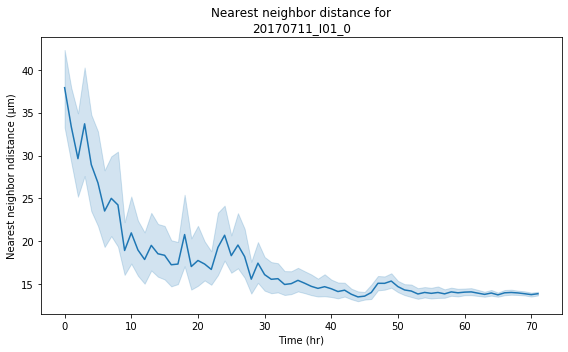

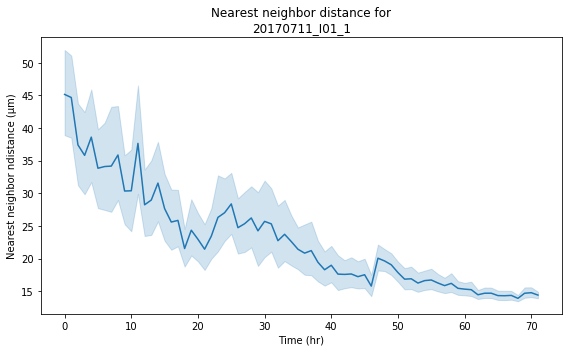

In [4]:
rep_dir_name = 'rep'
rep_dir = absolute_local_staging / rep_dir_name
rep_dir.mkdir(parents=True, exist_ok=True)

manifest = []
for i in range(len(exp_log_manifest)):
    original_image = exp_log_manifest.iloc[i].original_image_series
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    sns.lineplot('t', 'nndist', data=exp[i], ax=ax)
    ax.set(xlabel="Time (hr)", 
           ylabel="Nearest neighbor ndistance (µm)", 
           title=f"Nearest neighbor distance for\n{original_image}", 
          )
    plt.tight_layout()
    fn = rep_dir/f"nndist_experimental_{original_image}.pdf"
    manifest.append(dict(filepath=str(fn)))
    fig.savefig(fn)

And for the models, separately and coloring by influence decay:

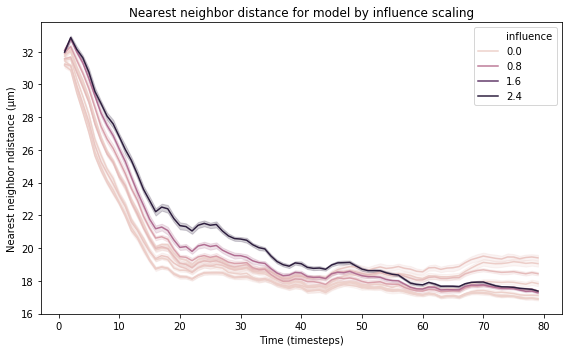

In [5]:
just_nndist = mod.groupby(['t', 'influence', 'copy'], as_index=False)['nndist'].mean()
just_nndist = just_nndist[just_nndist.t<80]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.lineplot('t', 'nndist', 'influence', data=just_nndist, ax=ax)
ax.set(xlabel="Time (timesteps)", 
       ylabel="Nearest neighbor ndistance (µm)", 
       title=f"Nearest neighbor distance for model by influence scaling", 
      )
plt.tight_layout()
fn = rep_dir/f"nndist_models_by_influence.pdf"
manifest.append(dict(filepath=str(fn)))
fig.savefig(fn)

That is the cannonical plot. Let's get the 3D version of it too:

In [6]:
T = np.sort(just_nndist.t.unique())
INFLUENCE = np.sort(just_nndist.influence.unique())
TT, INFINF = np.meshgrid(T, INFLUENCE)
NNDIST = np.ones((len(INFLUENCE), len(T)))
for i, influence in enumerate(INFLUENCE):
        for j, t in enumerate(T):
            NNDIST[i, j] = np.mean(just_nndist[(just_nndist.t==t) & (just_nndist.influence==influence)]['nndist'].values)

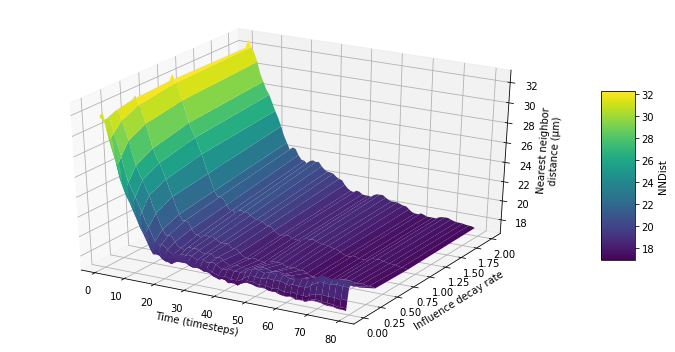

In [7]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(TT, INFINF, NNDIST, cmap=plt.cm.viridis)

yticklabels = ["%0.3f"%y for y in INFLUENCE]
ax.set(xlabel='Time (timesteps)', 
       ylabel='Influence decay rate', 
       zlabel="Nearest neighbor\ndistance (µm)")
fig.colorbar(surf, shrink=0.5, aspect=5, label="NNDist")
plt.tight_layout()
fn = rep_dir/f"nndist_models_by_influence_3d.pdf"
manifest.append(dict(filepath=str(fn)))
fig.savefig(fn)

And subtract the mean at every time point to see trends more clearly:

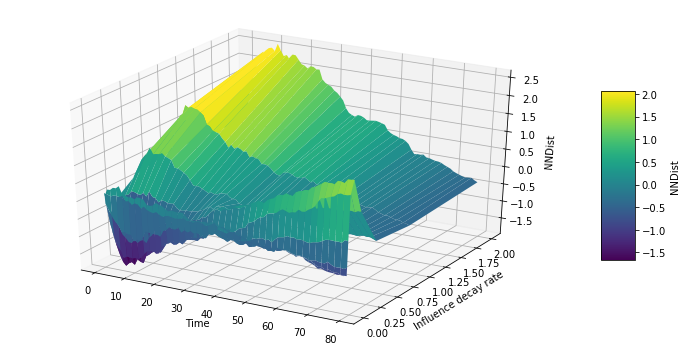

In [8]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(TT, INFINF, NNDIST-NNDIST.mean(0), cmap=plt.cm.viridis)

ax.set(xlabel='Time', ylabel='Influence decay rate', zlabel="NNDist")
fig.colorbar(surf, shrink=0.5, aspect=5, label="NNDist")
plt.tight_layout()
fn = rep_dir/f"nndist_models_by_influence_3d_mean_subtracted.pdf"
manifest.append(dict(filepath=str(fn)))
fig.savefig(fn)

And write out the manifest boilerplate:

In [9]:
for entry in manifest:
    entry['filepath'] = relative_local_staging/'rep'/Path(entry['filepath']).name
config.manifest = pd.DataFrame(manifest, index=range(len(manifest)))
utils.dump_step_config(config)
config.manifest.head(2)

,filepath
0,local_staging/met2rep/rep/nndist_experimental_...
1,local_staging/met2rep/rep/nndist_experimental_...


And we're done